In [1]:
# import all stuff we will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import random
import time
import scipy.stats as st

from numpy.random import randn
from scipy.optimize import fsolve
from yf import yf
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# 1.3 Day-count convention

If $t_1=d_1/m_1/y_1$ and $t_2=d_2/m_2/y_2$ are two dates, then the year fraction between these dates is defined as 

\begin{equation*}
\frac{\min\{d_2,30\}-\min\{d_1,30\}}{360}+\frac{m_2-m_1}{12}+y_2-y_1\;.
\end{equation*}

For example, according to this definition, the are 

\begin{equation*}
\frac{\min\{30,30\}-\min\{12,30\}}{360}+\frac{8-1}{12}+2018-2015=3.6\overline{3}
\end{equation*}

years (or $1308$ days) between $t_1=12/1/2015$ and $t_2=30/8/2018$. We implement the formula in the function <span style="color:orange">yf.py</span>.

In [2]:
help(yf)

Help on function yf in module yf:

yf(t1, t2)
    Measures the year fraction between dates t1 and t2>t1 according to the
    30/360 European day count convention.
    
    t1 is the tuple (dd,mm,yyyy), t2 is a list of tuples 
    [(dd,mm,yyyy),...,(dd,mm,yyyy)]. Tau = yf(t1,t2) is an array, where Tau[j] 
    is the corresponding year fraction between t1 and t2[j].
    
    Example
    t1 = (28,6,2017)
    t2 = [(5,10,2017),(5,1,2018),(5,4,2018)]
    
    Tau = yf(t1,t2)



In [3]:
yf((12,1,2015),[(30,8,2018)])[0]

3.6333333333333333

# 1.4 Combinations

We plot the profit diagram of the following outperformance product

- buy (long) one share of underlying with price $s = S_0 = 77.45$
- buy (long) one call option on the underlying with strike $X_1 = S_0$ and price $V_c(s,0;X_1) = 5.50$
- sell (short) two call options on the underlying each with strike $X_2 = 1.2S_0$ and price $V_c(s,0;X_2) = 1.20$

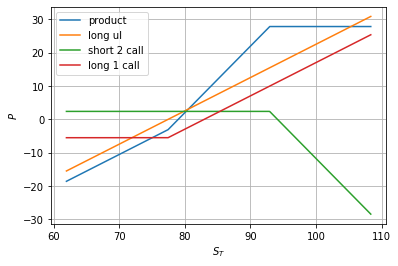

In [4]:
s = 77.45; X1 = s; X2 = 1.2*s; # underlying, strikes
prices = np.array([[5.5],[1.2]]) # the option prices 
n_long = 1; n_short = 2; # 'n_long' long call with strike X1, 'n_short' short call with strike X2

# draw the profit diagram of the outperformance product
V0 = s+n_long*prices[0]-n_short*prices[1]
profit = lambda x,X1,X2,V0: x+n_long*np.maximum(x-X1,0)-n_short*np.maximum(x-X2,0)-V0;
x = np.arange(0.8*s,1.4*s,0.1);
plt.plot(x,profit(x,X1,X2,V0)); plt.plot(x,x-s);
plt.plot(x,-n_short*np.maximum(x-X2,0)+n_short*prices[1]);
plt.plot(x,n_long*np.maximum(x-X1,0)-n_long*prices[0]);
plt.grid()
plt.legend(['product','long ul','short %i call' %n_short,'long %i call'%n_long])
plt.xlabel('$S_T$'), plt.ylabel('$P$');

# 1.5 A case study

We consider the hypothetical product written on Roche defined below

\begin{array}{l|l}
{\rm Issuer} & {\rm Eternity\;Investments\;EI} \\
{\rm Underlying} & {\rm Roche\;ROGN} \\
{\rm Initial\; Fixing\;IF} & {\rm CHF}\;286.10 \\
{\rm Initial\;Fixing\;Date} & {\rm October}\;4, 2019 \\
{\rm Final\;Fixing\;Date} & {\rm October}\;2, 2020 \\
{\rm Redemption\;Date} & {\rm October}\;9, 2020\\\hline
{\rm Redemption} & {\rm The\;Investor\;is\;entitled\;to\;receive\;from\;the\;Issuer}\\
& {\rm on\;the\;Redemption\;Date\;per\;Product:} \\
& {\rm The\;Maximum\;of\;the\;Underlying\;minus} \\
& {\rm the\;Minimum\;of\;the\;Underlying} \\\hline
{\rm Maximum} & {\rm The\;realised\;maximum\;of\;the\;official\;daily\;close} \\
& {\rm of\;the\;Underlying\;during\;the\;observation\;period.} \\\hline
{\rm Minimum} & {\rm The\;realised\;minimum\;of\;the\;official\;daily\;close} \\
& {\rm of\;the\;Underlying\;during\;the\;observation\;period.} \\ \hline
{\rm Observation\;period} & {\rm Each\;business\;day\;from\;October}\;4,\;2019 \\
& {\rm to\;Final\;Fixing\;Date.} \\\hline
{\rm Calculation\;Examples} & {\rm Minimum\;\;Maximum\;\;Redemption} \\
& 270\qquad\quad 340\qquad \quad 70 \\
& 250\qquad\quad 300\qquad \quad 50 \\
& 220\qquad\quad 300\qquad \quad 80 \\
\end{array}

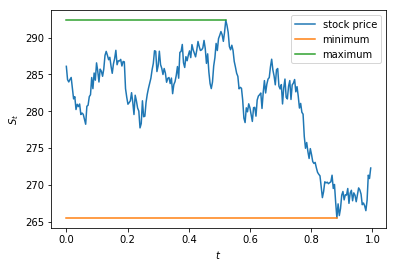

Assume that you purchase this product at issuance and that you hold it until maturity. The goal of this case study is to answer the following question:

<span style="color:red">How much you are willing to pay at issuance for this product?</span>

Here are a few observations. At maturity, the investor is entitled to receive the cash flow 

\begin{equation*}
g(S_{t_0},\ldots,S_{t_J}):=\max\{S_{t_0},\ldots,S_{t_J}\}-\min\{S_{t_0},\ldots,S_{t_J}\}\;,
\end{equation*}

where $S_t$ denotes the price of the underlying at time $t$ (with $S_0=286.10$) and $t_0,t_1,\ldots,t_J$ indicate the observation dates. The future time evolution of the underlying (its path) is not known, and so isn't the cash flow the investor receives. For example, the path of the underlying shown above is just one of many possible scenarios, each of these scenarios generates a cash flow at maturity. By the principle of financial equivalence, we need to discount the cash flow generated by a scenario to the date of issuance. This discounted random cash flow might be an estimate for the value/price of the product. To obtain a reasonable price, we should therefore generate as many scenarios for the time evolution of the underlying as possible and calculate for each of these scenarios the discounted cash flow. Then we average over all discounted cash flows. 

In [ ]:
We find the price of the product by the following <span style="color:red">Monte Carlo simulation</span>.

1. Denote by $t=0$ the date of issuance of the product and by $t=T$ the date of  maturity of the product. In the time interval $[0,T]$ generate $n$ paths $t\mapsto S_t$ of the underlying, i.e., generate $$$$ $$(s_0^k,s_1^k,\ldots,s_J^k), \quad k=1,\ldots,n\;.$$ $$$$Herewith, $s_j^k$ denotes the $k$-th realisation of the random variable $S_{t_j}$ at observation date $t_j$.

2. For each of the generated paths, evaluate the payoff function $g$, that is find the max and the min of the prices $s_j^k$ and take the difference, i.e., $$$$ $$ g_k:=\max\{s_0^k,\ldots,s_J^k\}-\min\{s_0^k,\ldots,s_J^k\}\;.$$ $$$$ This gives the redemption/cash flow for all the generated paths.

3. Discount the cash flows just found in 2.) to the date of issuance, $$v_k:=e^{-rT}g_k\;.$$

4. Take the mean of all $n$ discounted cash flows calculated in 3.) $$$$ $$V_n:=\frac{1}{n}\sum_{k=1}^ne^{-rT}g_k=e^{-rT}\frac{1}{n}\sum_{k=1}^ng_k\;.$$ $$$$ This mean is an estimator of the value of the product.

We model the time evolution of the stock price $S_t$ as a geometric Brownian motion (see chapter 2 for details). In Python this can be realised as follows, where we use the following parameters

$s_0$ is the price of the stock at issuance $t=0$. In this example $s_0=286.10$.

$T$ is the maturity of the product. In this example $T=358/360$.

$J$ is number of evenly spaced observation dates $t_j=j\frac{T}{J}$. In this example $J=252$.

$\sigma$ is the (annual, implied) volatility of the stock. In this example $\sigma=0.0753$.

$r$ is the continuously compounded risk free. In this example $r=-0.0063$.

$q$ is the continuously compounded dividend yield. In this example $q=0.0310$.

Simulate one path ..

In [ ]:
s0 = 286.1; T = 358/360; J = 252; sigma = 0.0753; r = -0.0063; q = 0.0310; # model- and contract parameters
dt = T/J; tj = np.arange(dt,T+dt,dt); 
tj = np.reshape(np.asarray(tj),[J,1]); t = np.vstack((np.asarray([[0.0]]),tj))
Z = randn(1,J); X = np.cumsum(Z,axis=1)
s = s0*np.exp((r-q-0.5*sigma**2)*tj+sigma*np.sqrt(dt)*X.T) # the stock prices at tj, excluding s0
s = np.vstack((np.asarray(s0),s)) # the stock prices at tj, including s0

In [ ]:
.. and plot it. Furthermore, get the payoff $g_k$ of the product for this scenario

31.154230981835326

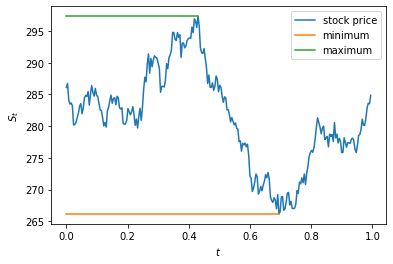

In [3]:
plt.plot(t,s)
plt.plot(np.array([0.0,t[s==np.min(s)]]),np.array([np.min(s),np.min(s)]))
plt.plot(np.array([0.0,t[s==np.max(s)]]),np.array([np.max(s),np.max(s)]))
plt.xlabel('$t$'); plt.ylabel('$S_t$');
plt.legend(('stock price','minimum','maximum'));
g = np.max(s)-np.min(s)
display(g)

To get an estimate of the value of the product, repeat the above $n$ times (without plotting).

In [4]:
n = 5*10**4; v = np.zeros(n)
for j in range(0,n):
    Z = randn(1,J); X = np.cumsum(Z,axis=1)
    s = s0*np.exp((r-q-0.5*sigma**2)*tj+sigma*np.sqrt(dt)*X.T)
    s = np.vstack((np.asarray(s0),s))
    v[j] = np.max(s)-np.min(s) # the payoff

# average and discount
v = np.exp(-r*T)*np.mean(v); display(v)

33.823515868815505

# 1.6 Why we do need models

### Example 1.2 

On September 3, 2019, the market price of a call option with strike $X=110$ CHF and with maturity November 15, 2019, on Nestle (which trades at $s_0=111.34$ CHF) is equal to $V^{\textrm M}=3.72$ CHF (average of bid and ask price). We use the bootstrap procedure described in the script to price this option without any model.

#### Solution.
Load daily closing prices of Nestle from September 3, 2018, to September 2, 2019, and calculate the (daily) log-returns.

In [2]:
data_nesn = pd.read_excel('nesn_03092018-02092019.xlsx', sheet_name='Tabelle1')

In [3]:
data_nesn

,Dates,Price
0,2018-09-03,81.50
1,2018-09-04,80.50
2,2018-09-05,79.90
3,2018-09-06,79.96
4,2018-09-07,80.24
5,2018-09-10,81.20
6,2018-09-11,80.62
7,2018-09-12,81.24
8,2018-09-13,81.14
9,2018-09-14,81.28


In [4]:
P = data_nesn['Price']

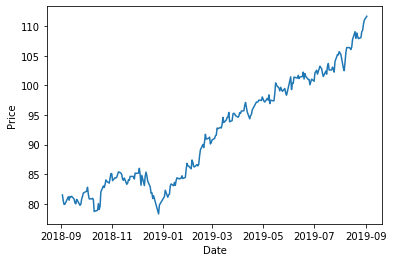

In [5]:
# look at the price history of Nestle
plt.plot(data_nesn['Dates'],P); plt.xlabel('Date'); plt.ylabel('Price');

Get the log-returns 

$$r_j^c=\ln\frac{p_{j+1}}{p_j}, \quad j=1,2,\ldots,n$$

In [6]:
R = np.log(np.asarray(P[1:])/np.asarray(P[0:-1]))

Prepare for the bootstrap.

In [7]:
s0 = 111.34; X = 110; r = -0.0088; # inital fixing, strike of the call, risk-free
T = np.int(yf((3,9,2019),[(15,11,2019)])[0]*360) # number of days 'til expiry of the call
B = 5*10**6; ST = np.zeros(B) # number of bootstrap samples

Do the bootstrap described in the script to obtain the model-free price

\begin{equation*}
V^B:=e^{-rT/360}\frac{1}{B}\sum_{b=1}^B\max\{s_T^b-X,0\}\;; \quad s_T^b=s_0e^{\sum_{k=1}^Tr_k^{c,\ast b}}\;.
\end{equation*}

of the call. For pedagocial reasons only, do this twice: With and without a for-loop.

In [8]:
# bootstrap via for-loop
# note: np.random.randint(n,size=(1,T)) draws uniformly T integers from the set {0,1,..,n-1} with replacement
t = time.time()
for j in range(0,B):
    idx = np.random.randint(len(R),size=(1,T))
    ST[j] = s0*np.exp(np.sum(R[idx])) # the price of the underlying at expiry

V = np.exp(-r*T/360)*np.mean(np.maximum(ST-X,0)) # average the cash flows of the call at expiry and discount
elapsed = time.time() - t
V, elapsed

(12.718001497036946, 134.8682086467743)

In [9]:
# repeat the above, but without a for-loop: this is (much) faster, but requires (much) more memory ...
t = time.time()
idx = np.random.randint(len(R),size=(B,T))
ST = s0*np.exp(np.sum(R[idx],axis=1))
V = np.exp(-r*T/360)*np.mean(np.maximum(ST-X,0))
elapsed = time.time() - t
V, elapsed

(12.71703373531322, 9.749944686889648)

The model-free price $V^B\approx 12.72$ is completely different from the market price! To see why, recall that the exponent $\sum_{k=1}^Tr_k^{c,\ast b}$ is - under the iid assumption and for $T$ large enough - normally distributed $\mathcal{N}(\mu,\sigma^2)$. Hence, estimate $\mu$ and $\sigma$ ...

In [10]:
RT = np.sum(R[idx],axis=1); # the sum in the exponent
args_n = st.norm.fit(RT) # fit to a normal distribution to obtain mu and sigma
mu = args_n[0]; sigma = args_n[1]
mu, sigma

(0.0914506704665215, 0.07606910266301031)

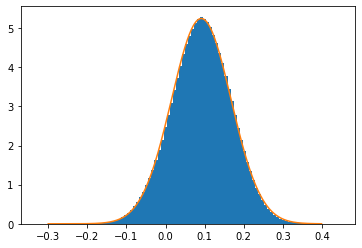

In [11]:
# check graphically the normality
plt.hist(RT,bins=100,density=True);
x = np.arange(-0.3,0.4,0.001)
plt.plot(x,st.norm.pdf(x,*args_n));

We might also directly fit the final stock price $s_T$ to a lognormal distribution.

In [12]:
argsln = st.lognorm.fit(ST,floc=0)
argsln

(0.07606910266301031, 0.0, 122.00222145583726)

Note that the first argument of "argsln" is equal to $\sigma$ from above, whereas the third argument is equal to $s_0e^{\mu}$:

In [13]:
s0*np.exp(mu)

122.00222145583709

Note also that the mean stock price at maturity is equal to $\mathbb{E}[S_T]=s_0e^{\mu+\sigma^2/2}$. This is confirmed by the data

In [14]:
np.mean(ST), s0*np.exp(mu+sigma**2/2)

(122.35525721219983, 122.35571602247929)

For illustration purposes, plot some paths $(s_1^b,s_2^b,\ldots,s_T^b)$ and the density of $s_T$, which is

$$f(x)=\frac{1}{\sqrt{2\pi\sigma^2}x}e^{-\frac{(\ln(x/s_0)-\mu)^2}{2\sigma^2}}=\frac{1}{\sqrt{2\pi\sigma^2}x}e^{-\frac{(\ln(x)-\ln(s_0e^\mu))^2}{2\sigma^2}}$$

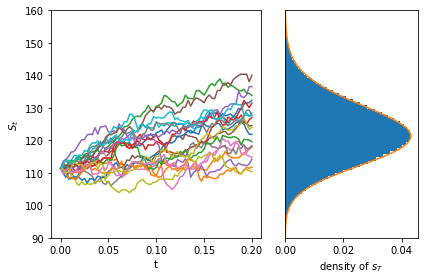

In [15]:
# graphical output
number_of_paths = 20; ymin = 90; ymax = 160;
t = np.arange(0,(T+1)/360,1/360)
x = np.arange(ymin,ymax,0.01)

fig = plt.figure(1)
gridspec.GridSpec(1,10)
ax1 = plt.subplot2grid((1,10), (0,0), colspan=6, rowspan=1)

for j in range(0,number_of_paths):
    idx = np.random.randint(len(R), size=(1,T))
    ax1.plot(t,np.hstack((s0,s0*np.exp(np.cumsum(R[idx])))));
    
plt.xlabel('t'); plt.ylabel('$S_t$');
ax1.set_ylim([ymin,ymax])
ax2 = plt.subplot2grid((1,10), (0,6),colspan=4, rowspan=1)
ax2.hist(ST, bins=100, orientation="horizontal",density=True);
#ax2.plot(st.lognorm.pdf(x,*argsln),x)
fln = lambda x: 1/(argsln[0]*x*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-np.log(argsln[2]))**2/(2*argsln[0]**2))
ax2.plot(fln(x),x)
ax2.set_ylim([ymin,ymax])
ax2.axes.get_yaxis().set_visible(False)
plt.xlabel('density of $s_T$');
fig.tight_layout()

If we assume that the exponent is indeed normal with mean $\mu$ and variance $\sigma^2$, then we may calculate the price of the call analytically. Indeed, the considerations of chapter 3 lead to the "pricing formula"

\begin{equation*}
V_c=e^{-rT/360}\big(s_0e^{\mu+\frac{1}{2}\sigma^2}N(d+\sigma)-XN(d)\big)
\end{equation*}

with $d=\frac{\ln\frac{s_0}{X}+\mu}{\sigma}$. We might evaluate the above formula for the present case:

In [16]:
# the pricing formula above as function of mu
d = lambda x:(np.log(s0/X)+x)/sigma
Vc = lambda x:np.exp(-r*T/360)*(s0*np.exp(x+sigma**2/2)*st.norm.cdf(d(x)+sigma)-X*st.norm.cdf(d(x)))
Vc(mu)

12.701901886756417

For the data above we find $V_c\approx 12.70$ CHF, which is of course close to the value $V^B$ obtained from the bootstrap. So, if the stock price at maturity is indeed lognormal (such that the above "pricing formula" is correct), then we obviously plugged in the wrong values for the parameters $\mu$ and/or $\sigma$ (as we should have obtained the market value $V^\textrm{M}=3.72$ CHF). To simplify things, assume that the (historical) volatility estimated above is the correct value for $\sigma$. Under this assumption, the only parameter which we plugged in wrongly into the above formula is $\mu$. The natural question is then: What value $\mu$ must attain such that the price $V_c$ (or equivalently, the price $V^B$) is equal to the market price $V^\textrm{M}=3.72$ CHF? 

To answer this question, we just solve the above "pricing formula" for $\mu$

In [17]:
VM = 3.72
mu_match = fsolve(lambda x:Vc(x)-VM,0.0)[0]
mu_match

-0.008594991875509276

The correct value for $\mu$ is $-0.86\%$, which is almost equal to the risk free $r=-0.88\%$!

We have seen above that the historical data suggests that the expected stock price of Nestle will be $\mathbb{E}[S_T]=s_0e^{\mu+\sigma^2/2}\doteq 122.36$ CHF at November 15, 2019. However, this "view" of market expectation is - as we have also seen - completely irrelevant to the price of the call: the option price ignores the "expected up-movement" $\mu\approx 9.15\%$ of Nestle. What is relevant in derivatives pricing is the risk free rate (and of course volatility, but that is a different story...)

As the "expected up-movement" of the underlying is reflected in the (bootstrapped) paths $(s_1^b,s_2^b,\ldots,s_T^b)$, these paths are the wrong ones to price the option! Thus, we need a mathematical model for the time evolution of the underlying which is able to "deliver" the correct paths. We will get to know such models in the forthcoming chapters.
